<a href="https://colab.research.google.com/github/abhishekambast/Fast_neural_Style_Transfer/blob/main/ImageTransformationNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models import vgg16, vgg19
from torchvision import transforms
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # For the transformation network, the authors only used 3x3 convolutions
        self.conv = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.out_channels,
                               kernel_size = 3)
        self.batch_norm = nn.InstanceNorm2d(self.out_channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        # First convolution
        orig_x = x.clone()
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)

        # Second convolution
        x = self.conv(x)
        x = self.batch_norm(x)

        # Now add the original to the new one (and use center cropping)

        height_diff = orig_x.size()[2] - x.size()[2]
        width_diff = orig_x.size()[3] - x.size()[3]

        # Add the original to the new (complete the residual block)
        x = x + orig_x[:, :,height_diff//2:(orig_x.size()[2] - height_diff//2), width_diff//2:(orig_x.size()[3] - width_diff//2)]

        return x

In [ ]:
class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        # Use reflection padding to keep the end shape
        self.ref_pad = nn.ReflectionPad2d(40)

        # Initial convolutions
        self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 32,kernel_size = 9,padding = 6,padding_mode = 'reflect')

        self.conv2 = nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 2)

        self.conv3 = nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3,stride = 2)

        # Residual Blocks
        self.resblock1 = ResidualBlock(in_channels = 128,out_channels = 128)

        self.resblock2 = ResidualBlock(in_channels = 128,out_channels = 128)

        self.resblock3 = ResidualBlock(in_channels = 128,out_channels = 128)

        self.resblock4 = ResidualBlock(in_channels = 128,out_channels = 128)

        self.resblock5 = ResidualBlock(in_channels = 128,out_channels = 128)

        # Transpose convoltutions
        self.trans_conv1 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)

        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=2,stride=2)

        # End with one last convolution
        self.conv4 = nn.Conv2d(in_channels = 32,out_channels = 3,kernel_size = 9,padding = 4,padding_mode = 'reflect')

    def forward(self, x):
        # Apply reflection padding
        x = self.ref_pad(x)

        # Apply the initial convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Apply the residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)

        #  Apply the transpose convolutions
        x = self.trans_conv1(x)
        x = self.trans_conv2(x)

        # Apply the final convolution
        x = self.conv4(x)

        return x

In [ ]:
# Test to confirm the residual network works
resblock = ResidualBlock(128, 128)
test = torch.randn(2, 128, 84, 84)
out = resblock(test)
print(out.size())

torch.Size([2, 128, 80, 80])


In [ ]:
# Test to confirm the transormational network works
transformation_net = ImageTransformationNetwork()
test = torch.randn(2, 3, 256, 256)
out = transformation_net(test)
print(out.size())

torch.Size([2, 3, 256, 256])


### Cost Functions
Now we must implement the different cost functions

Style Relu Indices: 3, 8, 15, 22  
Content Relu Index: 15

In [ ]:
class ForwardVGG19(torch.nn.Module):
    def __init__(self):
        super(ForwardVGG19, self).__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()

    def forward(self, x, style):
        results = []
        for i, model in enumerate(self.features):
            x = model(x)
            if style:
                if i in {3, 8, 15, 22}:
                    results.append(x)

            else:
                if i == 15:
                    results.append(x)

        return results

forward_vgg = ForwardVGG19()

C:\Users\Abhishek Ambast\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abhishek Ambast\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def normalize_batch(batch):
    """
    Before we send an image into the VGG19, we have to normalize it
    """
    # Define the means and standard deviations
    vgg_means = [0.485, 0.456, 0.406]
    vgg_std = [0.229, 0.224, 0.225]

    # Clone the batch to make changes to it
    ret = batch.clone()

    # Normalize to between 0 and 255 (input image is 255-value images, not floats)
    ret = ret / 255.0

    # Subtract the means and divide by the standard deviations
    ret[:, 0, :, :] = (ret[:, 0, :, :] - vgg_means[0]) / vgg_std[0]
    ret[:, 1, :, :] = (ret[:, 1, :, :] - vgg_means[1]) / vgg_std[1]
    ret[:, 2, :, :] = (ret[:, 2, :, :] - vgg_means[2]) / vgg_std[2]
    return ret

In [ ]:
def denormalize_batch(batch):
    vgg_means = [123.68, 116.779, 103.94]
    ret = torch.zeros(*batch.size())
    ret[:, 0, :, :] = batch[:, 0, :, :] + vgg_means[0]
    ret[:, 1, :, :] = batch[:, 1, :, :] + vgg_means[1]
    ret[:, 2, :, :] = batch[:, 2, :, :] + vgg_means[2]
    return ret

In [ ]:
def add_noise(batch):
    """
    For the input image, we have to add noise so that the loss between the content image and
    input image is not 0
    """
    mean = 0.0
    std = 10.0
    ret = batch + np.random.normal(mean, std, batch.shape)
    ret = np.clip(batch, 0, 255)
    return ret

In [ ]:
def compute_gram(matrix):
    """
    Computes the gram matrix
    """
    batches, channels, height, width = matrix.size()
    return (1/(channels * height * width)) * (torch.matmul(matrix.view(batches, channels, -1),
                                                torch.transpose(matrix.view(batches, channels, -1), 1, 2)))


In [ ]:
def content_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, False)
    target_layers = forward_vgg(target_norm, False)

    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + torch.mean(torch.square(input_layers[layer] - target_layers[layer]))

    return accumulated_loss

In [ ]:
def style_cost(input, target):
    # First normalize both the input and target (preprocess for VGG16)
    input_norm = normalize_batch(input)
    target_norm = normalize_batch(target)

    input_layers = forward_vgg(input_norm, True)
    target_layers = forward_vgg(target_norm, True)

    # layer weights
    layer_weights = [0.3, 0.7, 0.7, 0.3]

    # The accumulated losses for the style
    accumulated_loss = 0
    for layer in range(len(input_layers)):
        batches, channels, height, width = input_layers[layer].size()
        accumulated_loss = accumulated_loss + layer_weights[layer] * \
                            torch.mean(torch.square(compute_gram(input_layers[layer]) -
                                                    compute_gram(target_layers[layer])))

    return accumulated_loss

In [ ]:
def total_variation_cost(input):
    tvloss = (
        torch.sum(torch.abs(input[:, :, :, :-1] - input[:, :, :, 1:])) +
        torch.sum(torch.abs(input[:, :, :-1, :] - input[:, :, 1:, :]))
    )
    return tvloss

In [ ]:
content_losses = []
style_losses = []
tv_losses = []

In [ ]:
def total_cost(input, targets):
    # Weights
    REG_TV = 1e-6
    REG_STYLE = 1e6
    REG_CONTENT = 1.0

    # Extract content and style images
    content, style = targets

    # Get the content, style and tv variation losses
    closs = content_cost(input, content) * REG_CONTENT
    sloss = style_cost(input, style) * REG_STYLE
    tvloss = total_variation_cost(input) * REG_TV

    # Add it to the running list of losses
    content_losses.append(closs)
    style_losses.append(sloss)
    tv_losses.append(tvloss)

    print('****************************')
    print('Content Loss: {}'.format(closs.item()))
    print('Style Loss: {}'.format(sloss.item()))
    print('Total Variation Loss: {}'.format(tvloss.item()))

    # Apply the weights and add
    return closs + sloss + tvloss


### Data Loading

In [ ]:
# Constants
IMG_DIMENSIONS = (256, 256)
DATA = list(glob.iglob('archive/dataset/dataset_updated/training_set/iconography/*.jpg'))
file_path = 'archive/dataset/dataset_updated/training_set/drawings/1601_mainfoto_05.jpg'

# Define IMG_DIMENSIONS (width, height) for resizing the image


# Load the image using PIL and convert it to a NumPy array
style_image = np.asarray(Image.open(file_path).resize(IMG_DIMENSIONS))

# Transpose the image to have channels first (channels, width, height)
STYLE_IMAGE = style_image.transpose(2, 0, 1)
#STYLE_IMAGE = np.asarray(Image.open('archive\dataset\dataset_updated\training_set\drawings\1601_mainfoto_05.jpg').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]

# Make the style image a batch and convert
STYLE_IMAGE = STYLE_IMAGE.reshape(1, 3, 256, 256)
MAX_TRAIN = 500
MAX_VAL = 671
TOTAL_DATA = len(DATA)

In [ ]:
len(DATA)

671

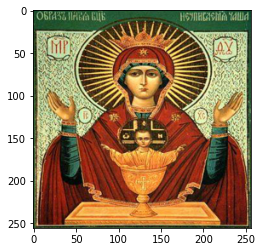

In [ ]:
for f in DATA[0:0+32]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))

        # If the image is grayscale, stack the image 3 times to get 3 channels

        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue


        # Transpose the image to have channels first
        plt.imshow(image)
        image = image.transpose(2, 0, 1)


In [ ]:
len(images)

NameError: name 'images' is not defined

(256, 256, 3)


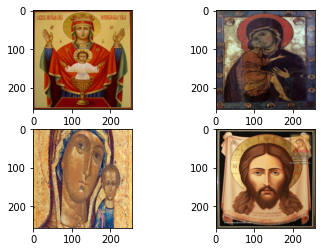

In [ ]:
def show_sample_images():
    f, axarr = plt.subplots(2,2)

    # Show colored images
    axarr[0,0].imshow(np.asarray(Image.open(DATA[0]).resize(IMG_DIMENSIONS)))
    axarr[0,1].imshow(np.asarray(Image.open(DATA[4]).resize(IMG_DIMENSIONS)))
    axarr[1,0].imshow(np.asarray(Image.open(DATA[8]).resize(IMG_DIMENSIONS)))

    # Grayscale example
    grayscale = np.asarray(Image.open(DATA[13]).resize(IMG_DIMENSIONS))
    print(grayscale.shape)
    #grayscale = np.stack((grayscale, grayscale, grayscale)).transpose(1, 2, 0)
    axarr[1,1].imshow(grayscale)

show_sample_images()

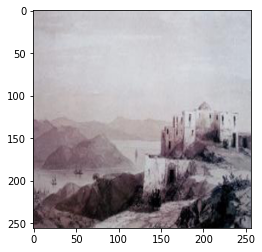

In [ ]:
# Show the chosen style image
plt.imshow(STYLE_IMAGE[0].transpose(1, 2, 0))

In [ ]:
def load_training_batch(current_batch, batch_size, set_type):
    """
    Load different batches of data (essentially a custom data loader for training, validation, and testing)
    """
    # The initial position is where we want to start getting the batch
    # So it is the starting index of the batch
    initial_pos = current_batch * batch_size

    # List to store the images
    images = []

    # Make sure the batch is within the [0, MAX_TRAIN]
    if set_type == 'train':
        if initial_pos + batch_size > MAX_TRAIN:
            batch_size = MAX_TRAIN - initial_pos

    # Make sure the batch is within the [MAX_TRAIN, MAX_VAL]
    elif set_type == 'val':
        initial_pos = MAX_TRAIN + initial_pos
        if initial_pos + batch_size > MAX_VAL:
            batch_size = MAX_VAL - initial_pos

    # Make sure the batch is within the [MAX_VAL, TOTAL_DATA]
    elif set_type == 'test':
        initial_pos = MAX_VAL + initial_pos
        if initial_pos + batch_size > TOTAL_DATA:
            batch_size = TOTAL_DATA - initial_pos

    for f in DATA[initial_pos:initial_pos + batch_size]:
        # Resize the image to 256 x 256
        image = np.asarray(Image.open(f).resize(IMG_DIMENSIONS))

        # If the image is grayscale, stack the image 3 times to get 3 channels

        if image.shape == IMG_DIMENSIONS:
            image = np.stack((image, image, image))
            images.append(image)
            continue


        # Transpose the image to have channels first
        image = image.transpose(2, 0, 1)
        images.append(image)

    return np.array(images)

In [ ]:
def training_show_img():
    # Get an image from the validation set
    img = load_training_batch(0, 10, 'val')[4]

    # Convert to tensor
    train_img = torch.from_numpy(img.reshape(1, 3, 256, 256)).float()

    # Put through network
    gen_img = transformation_net(train_img)
    gen_img = gen_img.detach().numpy()

    # Clip the floats
    gen_img = np.clip(gen_img, 0, 255)

    # Convert to ints (for images)
    gen_img = gen_img.astype('uint8')
    gen_img = gen_img.reshape(3, 256, 256).transpose(1, 2, 0)

    # Show the image
    plt.imshow(gen_img)
    plt.show()

In [ ]:

def show_img(img):
    # Convert to tensor
    img = torch.from_numpy(img.reshape(1, 3, 256, 256)).float()

    # Put through network
    gen_img = transformation_net(img)
    gen_img = gen_img.detach().numpy()

    # Clip the floats
    gen_img = np.clip(gen_img, 0, 255)

    # Convert to ints (for images)
    gen_img = gen_img.astype('uint8')
    gen_img = gen_img.reshape(3, 256, 256).transpose(1, 2, 0)

    # Show the image
    plt.imshow(gen_img)
    plt.show()

In [ ]:
def plot_losses():
    # Print info about content losses
    plt.plot(content_losses[int(len(content_losses) * 0.0):])
    plt.show()
    print(content_losses[len(content_losses) - 1])

    # Print info about style losses
    plt.plot(style_losses[int(len(style_losses) * 0.0):])
    plt.show()
    print(style_losses[len(style_losses) - 1])

    # Print info about total variation losses
    plt.plot(tv_losses[int(len(tv_losses) * 0.0):])
    plt.show()
    print(tv_losses[len(tv_losses) - 1])

### Training

In [ ]:
BATCH_SIZE = 4
STYLE_IMAGE_TENSOR = torch.from_numpy(np.copy(STYLE_IMAGE)).float()
transformation_net = ImageTransformationNetwork()
opt = optim.Adam(transformation_net.parameters(), lr=1e-3)

In [ ]:
for epoch in range(2):
    transformation_net.train()
    for batch, _ in enumerate(range(0, MAX_TRAIN, BATCH_SIZE)):
        # Skip what we've already done
        if epoch == 0 and batch < 7419:
            continue

        # The content batch is the same as the train batch, except train batch has noise added to it
        train_batch = load_training_batch(batch, BATCH_SIZE, 'train')

        content_batch = np.copy(train_batch)

        # Add noise to the training batch
        train_batch = add_noise(train_batch)

        # Convert the batches to tensors
        train_batch = torch.from_numpy(train_batch).float()
        content_batch = torch.from_numpy(content_batch).float()

        # Zero the gradients
        opt.zero_grad()

        # Forward propagate
        gen_images = transformation_net(train_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

        # Backprop
        loss.backward()

        # Clip the gradient to minimize chance of exploding gradients
        torch.nn.utils.clip_grad_norm_(transformation_net.parameters(), 1.0)

        # Apply gradients
        opt.step()

        print("Training Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))
        print('****************************')

        if batch % 500 == 499:
            training_show_img()
            plot_losses()

    transformation_net.eval()
    for batch, _ in enumerate(range(MAX_TRAIN, MAX_VAL, BATCH_SIZE)):
        # The content batch is the same as the train batch, except train batch has noise added to it
        val_batch = load_training_batch(batch, BATCH_SIZE, 'val')
        content_batch = np.copy(val_batch)

        # Add noise to the training batch
        val_batch = add_noise(val_batch)

        # Convert the batches to tensors
        val_batch = torch.from_numpy(val_batch).float()
        content_batch = torch.from_numpy(content_batch).float()

        # Forward propagate
        gen_images = transformation_net(val_batch)

        # Compute loss
        loss = total_cost(gen_images, [content_batch, STYLE_IMAGE_TENSOR])

        print("Validation Batch: {}".format(batch + 1), "Loss: {:f}".format(loss))



****************************
Content Loss: 27.809005737304688
Style Loss: 180.29483032226562
Total Variation Loss: 3.6454765796661377
Validation Batch: 1 Loss: 211.749313
****************************
Content Loss: 29.727006912231445
Style Loss: 170.40768432617188
Total Variation Loss: 3.4435102939605713
Validation Batch: 2 Loss: 203.578201
****************************
Content Loss: 21.695640563964844
Style Loss: 186.1125946044922
Total Variation Loss: 3.372382879257202
Validation Batch: 3 Loss: 211.180603
****************************
Content Loss: 19.792064666748047
Style Loss: 166.77186584472656
Total Variation Loss: 3.4418108463287354
Validation Batch: 4 Loss: 190.005753
****************************
Content Loss: 24.298870086669922
Style Loss: 258.4641418457031
Total Variation Loss: 4.658903121948242
Validation Batch: 5 Loss: 287.421906
****************************
Content Loss: 31.026784896850586
Style Loss: 240.97181701660156
Total Variation Loss: 4.364906311035156
Validation Batch

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 67108864 bytes.

In [ ]:
torch.save(transformation_net.state_dict(), 'models/starry_night_1e6_batch_7419.pt')

RuntimeError: Parent directory models does not exist.

In [ ]:
torch.save(transformation_net, 'our_model.pth')

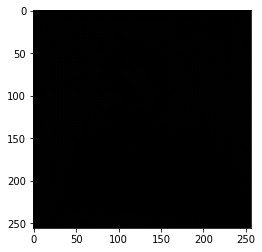

In [ ]:
training_show_img()

In [ ]:
plot_losses()

In [ ]:
mona_lisa = np.asarray(Image.open('archive/musemart/dataset_updated/training_set/drawings/2202_mainfoto_05.jpg').resize(IMG_DIMENSIONS)).transpose(2, 0, 1)[0:3]
mona_lisa.reshape(1, 3, 256, 256)

array([[[[205, 200, 197, ..., 189, 198, 202],
         [197, 193, 192, ..., 186, 192, 196],
         [196, 195, 194, ..., 190, 193, 196],
         ...,
         [153, 145, 145, ..., 101, 128, 140],
         [157, 149, 145, ..., 110, 124, 128],
         [143, 145, 149, ..., 150, 156, 157]],

        [[210, 205, 202, ..., 196, 200, 203],
         [202, 198, 197, ..., 193, 194, 197],
         [201, 200, 199, ..., 196, 195, 196],
         ...,
         [152, 143, 143, ...,  96, 125, 138],
         [153, 146, 141, ..., 104, 120, 125],
         [136, 138, 143, ..., 142, 150, 152]],

        [[203, 198, 195, ..., 189, 192, 195],
         [195, 191, 190, ..., 186, 187, 189],
         [194, 193, 193, ..., 192, 189, 191],
         ...,
         [139, 131, 131, ...,  86, 111, 123],
         [140, 133, 129, ...,  92, 104, 108],
         [121, 123, 128, ..., 129, 134, 134]]]], dtype=uint8)

In [ ]:
show_img(mona_lisa)

<ipython-input-28-b8041b562bba>:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:212.)
  img = torch.from_numpy(img.reshape(1, 3, 256, 256)).float()


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2230272 bytes.